# Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Постановка задачи

Задача состоит в построении простой модели сетевого протокола сети под названием TokenRing.
Ниже перечислены базовые особенности данного протокола:
1. Система состоит из N пронумерованных от 0 до N-1 узлов (потоков). Узлы упорядочены по порядковому номеру. После состояния N-1 следует узел 0, т.е. узлы формируют кольцо. 
2. Соседние в кольце потоки могут обмениваться пакетами. Обмен возможен только по часовой стрелке. 
3. Каждый поток, получив пакет от предыдущего, отдает его следующему.
4. Пакеты не могут обгонять друг друга.

В рамках работы необходимо написать реализацию данного протокола на языке Java; замерить метрики, характеризующие работу алгоритма в зависимости от числа узлов и нагрузки; объяснить выявленные зависимости и при возможности оптимизировать данный протокол. 

# Описание составленной реализации

В рамках работы была построена следующая реализация протокола TokenRing.

Базовой сущностью для работы протокола является TokenRing.class.
При инициализации экземпляра данного класса в конструктор подаётся количество узлов в протоколе.
Экземпляр содержит в себе набор пронумерованных узлов - SimpleNode, и потоков в которых происходит выполнение протокола.

SimpleNode - сущность, которая содержит в себе поля: идентификатор, ссылка на следующую SimpleNode и очередь сообщений (в данной реализации используется ConcurrentLinkedQueue).
Логика по передаче сообщений находится в методе receiveMessage: если сообщение, которое пришло в узел не предназначено для данного узла, то оно помещается в очередь следующего узла, если прездназначено, то узел выполняет над ним некоторую логику(в текущий момент записывает в специальную коллекцию время, которое прошло между инициализацией сообщения на исходном узле и получением сообщения).

Сообщения представлены DTO сущностью - TransportMessage, которая содержит в себе идентификатор узла отправителя, идентификатор узла получателя, содержимое сообщения(payload), а также время инициализации(небольшой костыль сугубо для измерения времени прохождения сообщения внутри топологии узлов).

Для отправления сообщения по протоколу TokenRing, составлен Builder - MessageRequest.
С помощью методов from/to/with задаются соответственно отправитель/получатель/payload сообщения.
Метод execute() создаёт сообщение и помещает его в очередь узла отправителя.

Для того, чтобы протокол начал свою работу, необходимо вызвать у TokenRing метод start(), который запустит все потоки для выполнения.
Для завершения работы протокола необходимо вызвать метод close().

# Исследование зависимости времени прохождения сообщения по топологии от количества узлов

Для исследования данной зависимости был проведен ряд тестов.
В каждом тесте происходила инциализации TokenRing с заданным числом узлов.
Затем в топологию помещалось 10 000 сообщений без получателя для минимальной нагрузки и "разогрева" реализации.
После этого в TokenRing помещалась 1 000 сообщений, каждое из которых должно было пройти n-1 узлов.
При достижении узла получателя сообщение записывало время нахождения в топологии в специальный массив метрик.
На основании полученного массива высчитывалось среднее значение и дисперсия времени прохождения.
Измерения были проведены для количества узлов от 2 до 35.

Данные представлены в файле nodesAmount.csv.

In [15]:
nodes_data = pd.read_csv('nodesAmount.csv', sep=';')
nodes_data.head()

,NumNodes,Value,Err
0,2,1.976,0.271424
1,3,3.898,0.091596
2,4,1.000,0.000000
3,5,0.206,0.163564
4,6,3.000,0.000000


Ниже представлен график зависимости времени прохождения сообщения по топологии от числа узлов.

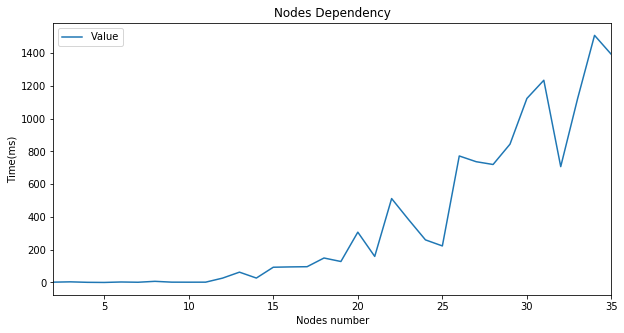

In [11]:
nodes_data_plot = nodes_data.plot('NumNodes', 'Value', title='Nodes Dependency', figsize=[10,5])
nodes_data_plot.set(xlabel='Nodes number', ylabel='Time(ms)')
plt.show()

По результатам эксперимента видно, что при количестве узлов меньше 10 сообщения проходят по кольцу за несколько миллисекунд.
Далее начинается сильное падение производительности (при количестве узлов более 28, сообщение проходит по кольцу более чем за секунду).

В качестве причин падения производительности можно привести следующие причины:

1) С ростом числа потоков на поддержание работы приложения требуется больше ресурсов; так как вычисления происходят на 4х ядерном процессоре, при маленьком числе потоков происходит фактическое распараллеливание работы, при числе потоков больше 10 прирост производительности от числа потоков падает, а расходы ресурсов на поддержание и переключение виртуальных потоков растут.

2) Чем больше потоков, тем больше раз нужно передать сообщение, чтобы оно дошло до получателя.

3) Ввиду того, что нагрузка между потоками не распределена равномерно, в очереди одного узла может скопится большое число сообщений, но при этом поток, "обслуживающий" данный узел будет ожидать освобождения ресурсов другими потоками. Чем больше число узлов, тем более вероятно возникновение задержек такого рода, и следовательно, падение производительности.

# Исследование зависимости времени прохождения сообщения по топологии от количества узлов

Для данного исследования был проведен ряд измерений, аналогичных предыдущим.
Отличительной особенностью этих измерений являлось то, что количество узлов являлось фиксированным и равным 8(число было подобрано по результатам прошлого эксперимента).
В качестве изменяемого параметра в данном исследовании выступило количество сообщений без получателя, иными словами нагрузка на топологию.
Перед измерениями времени прохождения сообщения по кольцу, в топологию помещалось некоторое число сообщений без получателя, которые бесконечно передвигались по кругу.
Измерения были проведены для количества сообщений без получателя от 0 до 10 000 000.

In [28]:
load_data = pd.read_csv('messagesInRing.csv', sep=';')
load_data

,Messages,Value,Err
0,0,0.003,-3.105155e-19
1,10,0.006,-3.521489e-19
2,100,0.002,-4.336809e-20
3,1000,0.010,-3.556183e-19
4,10000,2.134,1.025846e-16
5,100000,22.561,5.684342e-17
6,1000000,192.387,-4.547474e-16
7,10000000,4829.329,2.764864e-13


Ниже представлен график зависимости времени прохождения сообщений по топологии от числа нагрузочных сообщений в логарифмическом масштабе.

C:\Users\Maxim\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2923: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


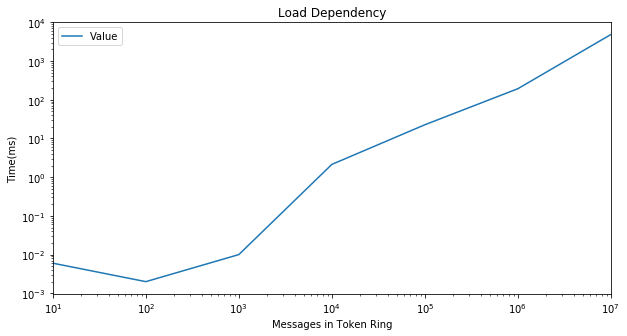

In [29]:
load_data_plot = load_data.plot('Messages','Value', logx=True, logy=True, title='Load Dependency', figsize=[10,5])
load_data_plot.set(xlabel='Messages in Token Ring', ylabel='Time(ms)')
plt.show()

Из полученных результатов можно сделать вывод, что зависимость времени прохождения от числа сообщений в топологии близка к линейной.
Также стоит отметить высокую дисперсию измерений, столь высокую ошибку измерений можно объяснить аналогичным первому исследованию образом - неравномерная нагрузка на узлы/потоки и как следствие неравномерное распределение сообщений по узлам.

# Исследование зависимости времени прохождения сообщения по топологии от количества узлов при нагрузке

В рамках данного исследования был проведён ряд измерений аналогичных первому исследованию.
Отличительной особенностью этих измерений является число нагрузочных сообщений.
Если при первом эксперименте число нагрузочных сообщений составляло 10 000 то в данных измерениях число нагрузочных сообщений составляет 10 000 000.
Цель данного эксперимента - выяснить, как влияет число узлов на перегруженную сеть.

In [25]:
nodes_under_load = pd.read_csv('nodesUnderLoad.csv', sep=';')
nodes_under_load

,NumNodes,Value,Err
0,2,2344.036000,2.052573e+05
1,4,3523.483000,5.539890e+05
2,8,4985.135000,1.044122e+06
3,16,5562.030000,2.054831e+06
4,26,6279.591592,2.064669e+06
5,32,7816.428283,3.219393e+06
6,40,8066.375000,5.816030e+06


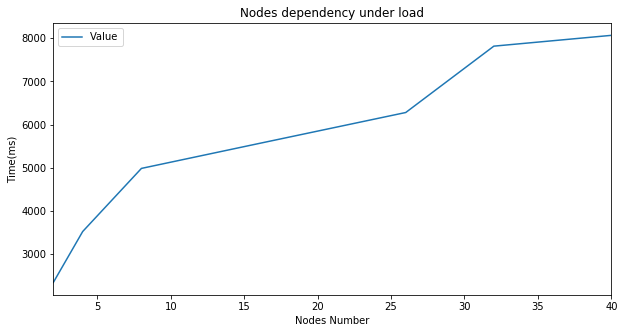

In [7]:
nodes_under_load_plot = nodes_under_load.plot('NumNodes','Value', title='Nodes dependency under load', figsize=[10,5])
nodes_under_load_plot.set(xlabel='Nodes Number', ylabel='Time(ms)')
plt.show()

По результатам измерений даже при перегруженной сети количество узлов только ухудшает производительность.
При этом при каждой серии измерений наблюдается очень высокая дисперсия, что подтверждает гипотезу об итоговом неравномерном распределении сообщений по узлам.

# Распределение сообщений по узлам

Для подтверждения гипотезы о неравномерном распределении сообщений по узлам, был проведён ряд измерений.
В топологию с 8 узлами запускался 1 000 000 сообщений, затем эти сообщения проходили по кругу в течении пяти секунд.
После этого происходила остановка протокола и считывалось количество сообщений оставшихся в узлах.

Результаты, представленные в таблице ниже, подтверждают гипотезу о том, что сообщения в топологии распределены неравномерно.

In [34]:
nodes_distr = pd.read_csv('messagesDistr.csv', sep=";", index_col='Index')
nodes_distr

,Node-0,Node-1,Node-2,Node-3,Node-4,Node-5,Node-6,Node-7,Unnamed: 9
Index,,,,,,,,,
0,0,142057,1,718206,14534,0,53733,71469,NaN
1,3,1,226264,254483,1,318694,200553,1,NaN
2,179,297263,23447,2,1097,8275,4,669733,NaN
3,50566,6702,315,37,1,300754,391071,250554,NaN
4,35645,272611,216552,110261,122547,150603,32755,59026,NaN
5,6072,13275,2,27684,371446,199179,382342,0,NaN
6,97893,0,27,4,336831,107334,364867,93044,NaN
7,82556,0,2,1,7,4,146645,770785,NaN
8,1,1,178576,775775,11352,33422,1,872,NaN


# Итоги

В ходе работы была построена реализация алгоритма TokenRing и выявлен ряд закономерностей данной реализации.

1) Задержка между отправлением и получением сообщения растёт с количеством узлов в топологии. При этом на сети с низкой нагрузкой рост задержки наблюдается при большом числе узлов (примерно больше 10).

2) При количестве сообщений в топологии превышающем 10 000 наблюдается линейная зависимость между текущим количеством сообщений в топологии и временем задержки.

3) При высокой нагрузке (условно 10 000 000 сообщений в топологии) увеличение узлов не приводит к разгрузке топологии и уменьшению времени задержки, а наоборот увеличивает его.

Основной причиной негативной корреляции времени задержки и числа узлов (кроме очевидного увеличения пути прохождения сообщения и увеличения расхода ресурсов на работу потоков) предполагается считать неравномерное распределение нагрузки между потоками.
Поток с узлом, содержащим большое количество сообщений может ждать освобождения ресурсов от других потоков, которые практически не выполняют никакой работы.

Данная проблема является особенностью работы потоков в jvm, а не самого протокола.
Для устранения данной проблемы и построения более корректной модели необходимо научиться разделять слабонагруженные узлы от сильнонагруженных  усыплять их для распределения работы.